# What is Intracranial Hemorrhage?
*An intracranial hemorrhage (ICH) is a condition in which a blood vessel erupts inside the brain, causing internal bleeding. If not treated correctly and immediately, a brain hemorrhage can be deadly. The type of hemorrhage is usually diagnosed using a CT or MRI scan. Some hemorrhages are also accompanied by cerebral edema – an excess accumulation of fluid in the intracellular or extracellular spaces of the brain.Edema is exceedingly difficult to identify, appearing as a subtle darker area surrounding the hemorrhage; it sometimes requires analysis of multiple sequential scans. Implementation and execution of a successful segmentation model in these situations requires expertise in all computer vision methods – both classical and deep learning based. RSIP Vision leverages both deep learning and classical computer vision techniques to provide a fully automated solution to this segmentation problem.*
to know more,watch [this video](https://www.youtube.com/watch?v=7RqjrCSR8TE) 

## Competition [here](https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection)

## So all the paths are according to  this path

 <font color="GREEN"><b> Typically Intracranial  Hemorrhage Detection is segmentation task like the diagram describing below </b></font>

![](https://www.rsipvision.com/wp-content/uploads/2018/07/Hemorrhage-Slide.jpg)

*source : https://www.rsipvision.com/intracranial-hemorrhage-and-edema-segmentation/*

## Types of Intracranial

![](http://pbs.twimg.com/media/BxqqVoyCQAAOE10.png)  

**Necessary imports**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# Any results you write to the current directory are saved as output.


import seaborn as sns
from sklearn.utils import shuffle
from os.path import isfile, join
import keras

# Standard dependencies
import cv2
import time
import scipy as sp
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt

# Machine Learning
import tensorflow as tf
import keras
from keras import initializers
from keras import regularizers
from keras import constraints
from keras import backend as K
from keras.activations import elu
from keras.optimizers import Adam
from keras.models import Sequential
from keras.engine import Layer, InputSpec
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D, Dropout
from sklearn.metrics import cohen_kappa_score
import pydicom

import json

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
from keras import layers
from keras.callbacks import Callback, ModelCheckpoint
from keras.models import Sequential
from keras.optimizers import Adam
from tqdm import tqdm

  
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
!ls ../input


efficientnetb0b7-keras-weights	rsna-intracranial-hemorrhage-detection


In [3]:
os.listdir('/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection')

['stage_2_train.csv',
 'stage_2_test',
 'stage_2_train',
 'stage_2_sample_submission.csv']

In [4]:
BASE_PATH = '/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/'
TRAIN_DIR = 'stage_2_train/'
TEST_DIR = 'stage_2_test/'
train_df = pd.read_csv(BASE_PATH + 'stage_2_train.csv')

In [5]:
train_df

,ID,Label
0,ID_12cadc6af_epidural,0
1,ID_12cadc6af_intraparenchymal,0
2,ID_12cadc6af_intraventricular,0
3,ID_12cadc6af_subarachnoid,0
4,ID_12cadc6af_subdural,0
...,...,...
4516837,ID_4a85a3a3f_intraparenchymal,0
4516838,ID_4a85a3a3f_intraventricular,0
4516839,ID_4a85a3a3f_subarachnoid,0
4516840,ID_4a85a3a3f_subdural,0


In [6]:
train_df.ID == 'ID_6431af929_intraparenchymal'

0          False
1          False
2          False
3          False
4          False
           ...  
4516837    False
4516838    False
4516839    False
4516840    False
4516841    False
Name: ID, Length: 4516842, dtype: bool

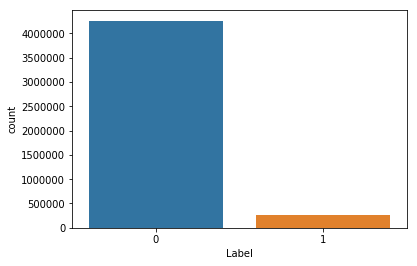

In [7]:
sns.countplot(train_df.Label)

In [8]:
train_df.Label.value_counts()

0    4260600
1     256242
Name: Label, dtype: int64

**As from above 2 cells we can see huge class imbalance problem in this competition**

In [9]:
sub_df = pd.read_csv(BASE_PATH + 'stage_2_sample_submission.csv')

train_df['filename'] = train_df['ID'].apply(lambda st: "ID_" + st.split('_')[1] + ".png")
train_df['type'] = train_df['ID'].apply(lambda st: st.split('_')[2])
sub_df['filename'] = sub_df['ID'].apply(lambda st: "ID_" + st.split('_')[1] + ".png")
sub_df['type'] = sub_df['ID'].apply(lambda st: st.split('_')[2])

print(train_df.shape)
train_df.head()

(4516842, 4)


,ID,Label,filename,type
0,ID_12cadc6af_epidural,0,ID_12cadc6af.png,epidural
1,ID_12cadc6af_intraparenchymal,0,ID_12cadc6af.png,intraparenchymal
2,ID_12cadc6af_intraventricular,0,ID_12cadc6af.png,intraventricular
3,ID_12cadc6af_subarachnoid,0,ID_12cadc6af.png,subarachnoid
4,ID_12cadc6af_subdural,0,ID_12cadc6af.png,subdural


**The original image size from the [EfficientNet paper](https://arxiv.org/pdf/1905.11946.pdf) for EfficientNetB3 is 300x300x3. We are however not bound by this and can use a smaller size if we want. The original image sizes used for every version of EfficientNet are**

* EfficientNetB0 - (224, 224, 3)
* EfficientNetB1 - (240, 240, 3)
* EfficientNetB2 - (260, 260, 3)
* EfficientNetB3 - (300, 300, 3)
* EfficientNetB4 - (380, 380, 3)
* EfficientNetB5 - (456, 456, 3)
* EfficientNetB6 - (528, 528, 3)
* EfficientNetB7 - (600, 600, 3)

**Image: an overview of model architectures and their performance on [ImageNet](http://www.image-net.org/). We can see that EfficientNet achieves state-of-the-art and uses a lot less parameters than most modern CNN architectures.**

![](https://warehouse-camo.cmh1.psfhosted.org/acfb05f8a49eb76db65cf17ac4455aa800f1ab37/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f74656e736f72666c6f772f7470752f6d61737465722f6d6f64656c732f6f6666696369616c2f656666696369656e746e65742f6733646f632f706172616d732e706e67)


![](https://warehouse-camo.cmh1.psfhosted.org/02731be4faa16b3d9288be054750067e2621f31a/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f74656e736f72666c6f772f7470752f6d61737465722f6d6f64656c732f6f6666696369616c2f656666696369656e746e65742f6733646f632f666c6f70732e706e67)

In [10]:
test_df = pd.DataFrame(sub_df.filename.unique(), columns=['filename'])
print(test_df.shape)
test_df.head()

(121232, 1)


,filename
0,ID_0fbf6a978.png
1,ID_d62ec3412.png
2,ID_cb544194b.png
3,ID_0d62513ec.png
4,ID_fc45b2151.png


In [11]:
train_df.shape

(4516842, 4)

In [12]:
np.random.seed(2019)
sample_files = np.random.choice(os.listdir(BASE_PATH + TRAIN_DIR), 400000)
sample_df = train_df[train_df.filename.apply(lambda x: x.replace('.png', '.dcm')).isin(sample_files)]

In [13]:
pivot_df = sample_df[['Label', 'filename', 'type']].drop_duplicates().pivot(
    index='filename', columns='type', values='Label').reset_index()
print(pivot_df.shape)
pivot_df

(310498, 7)


type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000012eaf.png,0,0,0,0,0,0
1,ID_000039fa0.png,0,0,0,0,0,0
2,ID_00008ce3c.png,0,0,0,0,0,0
3,ID_0001dcc25.png,0,0,0,0,0,0
4,ID_0001de0e8.png,0,0,0,0,0,0
...,...,...,...,...,...,...,...
310493,ID_ffff82e46.png,0,0,0,0,0,0
310494,ID_ffff922b9.png,1,0,0,1,0,0
310495,ID_ffffb670a.png,1,0,0,0,1,0
310496,ID_ffffcbff8.png,0,0,0,0,0,0


## windowing

**Source: https://www.kaggle.com/omission/eda-view-dicom-images-with-correct-windowing**

In [14]:
def window_image(img, window_center,window_width, intercept, slope, rescale=True):

    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    
    if rescale:
        # Extra rescaling to 0-1, not in the original notebook
        img = (img - img_min) / (img_max - img_min)
    
    return img
    
def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

**Resize 256x256**

In [15]:
def save_and_resize(filenames, load_dir):    
    save_dir = '/kaggle/tmp/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for filename in tqdm(filenames):
        try:
            path = load_dir + filename
            new_path = save_dir + filename.replace('.dcm', '.png')
            dcm = pydicom.dcmread(path)
            window_center , window_width, intercept, slope = get_windowing(dcm)
            img = dcm.pixel_array
            img = window_image(img, window_center, window_width, intercept, slope)

            resized = cv2.resize(img, (224, 224))
            res = cv2.imwrite(new_path, resized)
            
        except ValueError:
            continue
            

In [16]:
save_and_resize(filenames=sample_files, load_dir=BASE_PATH + TRAIN_DIR)
save_and_resize(filenames=os.listdir(BASE_PATH + TEST_DIR), load_dir=BASE_PATH + TEST_DIR)

 77%|███████▋  | 93143/121232 [13:34<03:49, 122.51it/s]

**Implementation of EfficientNetB4 for this competition with Keras**

In [17]:
!pip install -U efficientnet==0.0.4

  Created wheel for efficientnet: filename=efficientnet-0.0.4-cp36-none-any.whl size=14288 sha256=b52427165a1451c3a32445289619545e929769fa6a97529ef2fde0be8f35c788
  Stored in directory: /root/.cache/pip/wheels/5c/34/68/a611a699a28239e964ccf144c0e767cdb5439fee82ec5de6e0
Successfully built efficientnet


In [18]:
from efficientnet import EfficientNetB4

size = 224

In [19]:
#print(os.listdir("../input/efficientnetb0b7-keras-weights/efficientnet-b3_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5"))

In [20]:
effnet = EfficientNetB4(weights=None, include_top=False, input_shape=(size, size, 3))

effnet.load_weights('../input/efficientnetb0b7-keras-weights/efficientnet-b4_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5')

pivot_df is simply sample_df reformatted so that each column is a label (this way, we can use multi-label in our data generator later).

**Batch Normalization becomes unstable with small batch sizes (<16) **

## Why Group Normalization(GN) ????

*Group Normalization(GN) divides the channels into groups and computes within each group the mean and variance for normalization. GN’s computation is independent of batch sizes, and its accuracy is stable in a wide range of batch sizes. On ResNet-50 trained in ImageNet, GN has 10.6% lower error than its BN counterpart when using a batch size of 2; when using typical batch sizes, GN is comparably good with batch normalization BN and outperforms other normalization variants. Moreover, GN can be naturally transferred from pre-training to fine-tuning. GN can outperform its BN based counterparts for object detection and segmentation.*

to read more visit this link : https://analyticsindiamag.com/alternatives-batch-normalization-deep-learning/


In [21]:
class GroupNormalization(Layer):
    """Group normalization layer
    Group Normalization divides the channels into groups and computes within each group
    the mean and variance for normalization. GN's computation is independent of batch sizes,
    and its accuracy is stable in a wide range of batch sizes
    # Arguments
        groups: Integer, the number of groups for Group Normalization.
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `BatchNormalization`.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    # Output shape
        Same shape as input.
    # References
        - [Group Normalization](https://arxiv.org/abs/1803.08494)
    """

    def __init__(self,
                 groups=32,
                 axis=-1,
                 epsilon=1e-5,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(GroupNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.groups = groups
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        dim = input_shape[self.axis]

        if dim is None:
            raise ValueError('Axis ' + str(self.axis) + ' of '
                             'input tensor should have a defined dimension '
                             'but the layer received an input with shape ' +
                             str(input_shape) + '.')

        if dim < self.groups:
            raise ValueError('Number of groups (' + str(self.groups) + ') cannot be '
                             'more than the number of channels (' +
                             str(dim) + ').')

        if dim % self.groups != 0:
            raise ValueError('Number of groups (' + str(self.groups) + ') must be a '
                             'multiple of the number of channels (' +
                             str(dim) + ').')

        self.input_spec = InputSpec(ndim=len(input_shape),
                                    axes={self.axis: dim})
        shape = (dim,)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, **kwargs):
        input_shape = K.int_shape(inputs)
        tensor_input_shape = K.shape(inputs)

        # Prepare broadcasting shape.
        reduction_axes = list(range(len(input_shape)))
        del reduction_axes[self.axis]
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis] // self.groups
        broadcast_shape.insert(1, self.groups)

        reshape_group_shape = K.shape(inputs)
        group_axes = [reshape_group_shape[i] for i in range(len(input_shape))]
        group_axes[self.axis] = input_shape[self.axis] // self.groups
        group_axes.insert(1, self.groups)

        # reshape inputs to new group shape
        group_shape = [group_axes[0], self.groups] + group_axes[2:]
        group_shape = K.stack(group_shape)
        inputs = K.reshape(inputs, group_shape)

        group_reduction_axes = list(range(len(group_axes)))
        group_reduction_axes = group_reduction_axes[2:]

        mean = K.mean(inputs, axis=group_reduction_axes, keepdims=True)
        variance = K.var(inputs, axis=group_reduction_axes, keepdims=True)

        inputs = (inputs - mean) / (K.sqrt(variance + self.epsilon))

        # prepare broadcast shape
        inputs = K.reshape(inputs, group_shape)
        outputs = inputs

        # In this case we must explicitly broadcast all parameters.
        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            outputs = outputs * broadcast_gamma

        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            outputs = outputs + broadcast_beta

        outputs = K.reshape(outputs, tensor_input_shape)

        return outputs

    def get_config(self):
        config = {
            'groups': self.groups,
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(GroupNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

## Replace all Batch Normalization layers by Group Normalization layers

In [22]:

for i, layer in enumerate(effnet.layers):
    if "batch_normalization" in layer.name:
        effnet.layers[i] = GroupNormalization(groups=32, axis=-1, epsilon=0.00001)

**BCE DICE LOSS**

In [23]:
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [24]:
!pip install keras-rectified-adam
from keras_radam import RAdam

  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.17.0-cp36-none-any.whl size=14781 sha256=3af1f28a07e9107753ef9fef3c14a8219eec52f837ba8334600de4260114e7b3
  Stored in directory: /root/.cache/pip/wheels/7b/01/27/3a934e1a5644f5b93c720422a6ef97034ea78a21ba71cfb549
Successfully built keras-rectified-adam


In [25]:
def build_model():
    """
    A custom implementation of EfficientNetB4
    """
    model = Sequential()
    model.add(effnet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='sigmoid'))
    model.compile(loss=bce_dice_loss,
                  optimizer=RAdam(warmup_proportion=0.1,lr=0.00005), 
                  metrics=['accuracy'])
    print(model.summary())
    return model

In [26]:
# Initialize model
model = build_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 7, 7, 1792)        17423416  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1792)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1792)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 10758     
Total params: 17,434,174
Trainable params: 17,434,174
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
def preprocess_image(image, sigmaX=10):
    """
    The whole preprocessing pipeline:
    1. Read in image
    2. Apply masks
    3. Resize image to desired size
    4. Add Gaussian noise to increase Robustness
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (size, size))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    return image

## Attention please

keras team updated their utils.py file from keras-preprocessing github repository just 2 days ago(probably in 26th september,2019) (here:https://github.com/keras-team/keras-preprocessing/blob/master/keras_preprocessing/image/utils.py) so if you try to import and use ImageDataGenerator  old from keras.preprocessing.image import ImageDataGenerator then you will get error saying "ValueError: Invalid class_mode: other; expected one of: {'input', 'raw', None, 'multi_output', 'binary', 'sparse', 'categorical'}"

i got that error and spend few times on google to figure that out and solved it eventually

**Solution : **

as the keras-team just updated their utils file to use ImageDataGenerator now you will need to do !pip install git+https://github.com/keras-team/keras-preprocessing.git first then import ImageDataGenerator like this : from keras.preprocessing.image import ImageDataGenerator
so, instead of previous keras.preprocessing.image we need to use keras_preprocessing.image now,lets do it ;)

In [28]:
!pip install git+https://github.com/keras-team/keras-preprocessing.git

  Cloning https://github.com/keras-team/keras-preprocessing.git to /tmp/pip-req-build-v7r6dnem
  Running command git clone -q https://github.com/keras-team/keras-preprocessing.git /tmp/pip-req-build-v7r6dnem
  Created wheel for Keras-Preprocessing: filename=Keras_Preprocessing-1.1.0-cp36-none-any.whl size=42211 sha256=5719f386db6cdb86052a90785a13b31ab90732959303738016550c2181b1afab
  Stored in directory: /tmp/pip-ephem-wheel-cache-bp83mh6b/wheels/03/a0/39/171f6040d36f36c71168dc69afa81334351b20955dc36ce932
Successfully built Keras-Preprocessing


In [29]:
from keras_preprocessing.image import ImageDataGenerator

In [30]:
BATCH_SIZE = 32

def create_datagen():
    return ImageDataGenerator(validation_split=0.15)

def create_test_gen():
    return ImageDataGenerator().flow_from_dataframe(
        sub_df,
        directory=  '/kaggle/tmp/',
        x_col='filename',
        class_mode=None,
        target_size=(size, size),
        batch_size=BATCH_SIZE,
        shuffle=False
    )

def create_flow(datagen, subset):
    return datagen.flow_from_dataframe(
        pivot_df, 
        directory='/kaggle/tmp/',
        
        x_col='filename', 
        y_col=['any', 'epidural', 'intraparenchymal', 
               'intraventricular', 'subarachnoid', 'subdural'],
        class_mode='other',
        target_size=(size, size),
        batch_size=BATCH_SIZE,
        preprocessing_function=preprocess_image,
        rotation_range=360,
        horizontal_flip=True,
        validation_split=0.15,
        rescale=1 / 128.,
        subset=subset
    )

# Using original generator
data_generator = create_datagen()
train_gen = create_flow(data_generator, 'training')
val_gen = create_flow(data_generator, 'validation')
test_gen = create_test_gen()

/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 263923 validated image filenames.
Found 46574 validated image filenames.
Found 727392 validated image filenames.


In [31]:
checkpoint = ModelCheckpoint(
    'effnetb4.h5', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)
#train_length = len(train_df)
total_steps = sample_files.shape[0] // BATCH_SIZE
total_steps = total_steps // 4
history = model.fit_generator(
    train_gen,
    steps_per_epoch = total_steps,
    validation_data=val_gen,
    validation_steps=total_steps * 0.15,
    callbacks=[checkpoint],
    epochs=1
)

Epoch 1/1
3125/3125 [==============================] - 1869s 598ms/step - loss: 0.8320 - accuracy: 0.7276 - val_loss: 0.3880 - val_accuracy: 0.6264


**submission**

In [32]:
model.load_weights('effnetb4.h5')
y_test = model.predict_generator(
    test_gen,
    steps=len(test_gen),
    verbose=1
)

15299/22731 [===================>..........] - ETA: 16:05

In [33]:
# Append the output predicts in the wide format to the y_test
test_df = test_df.join(pd.DataFrame(y_test, columns=[
    'any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural'
]))

# Unpivot table, i.e. wide (N x 6) to long format (6N x 1)
test_df = test_df.melt(id_vars=['filename'])

# Combine the filename column with the variable column
test_df['ID'] = test_df.filename.apply(lambda x: x.replace('.png', '')) + '_' + test_df.variable
test_df['Label'] = test_df['value']

test_df[['ID', 'Label']].to_csv('submission.csv', index=False)

## Future Plans

1. trying focal instead of bce dice
2. using equal number of positive and negative samples for training
3. using bit more large size images

****I hope this kernel helpful and some <font color="RED"><b>UPVOTES</b></font> would be very much appreciated******

**REFERENCES**

- https://www.kaggle.com/xhlulu/rsna-intracranial-simple-densenet-in-keras
- https://www.kaggle.com/carlolepelaars/efficientnetb5-with-keras-aptos-2019
- https://www.kaggle.com/marcovasquez/basic-eda-data-visualization
- https://www.kaggle.com/allunia/rsna-ih-detection-eda-baseline

